In [1]:
from ase.io import read

import numpy as np
import os
import tempfile
from tqdm.auto import tqdm
import pickle
from skmatter.preprocessing import StandardFlexibleScaler
from skmatter.decomposition import PCovR
from rascal.representations import SphericalInvariants as SOAP
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.decomposition import PCA
from IPython.display import clear_output
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split

from scipy.spatial.distance import cdist

def rmse(*x):
    return np.sqrt(mse(*x))

plt.rcParams['pdf.fonttype']=42

SMALL_FONT=8
MEDIUM_FONT=10
LARGE_FONT=12

TMP_DIR = tempfile.TemporaryDirectory()

In [2]:
all_frames = read("ice_w_charges.xyz", ":")
all_energies = np.array([frame.info['energy [eV/H2O]'] for frame in all_frames])

all_frames = [frame for i, frame in enumerate(all_frames) if all_energies[i] <= -473.2]
print(len(all_frames))

15862


In [3]:
poly_names = [frame.info["name"] for frame in all_frames]
labels = [frame.info["label"] for frame in all_frames]
labeled = [
    i
    for i, v in enumerate(poly_names)
    if v != labels[i]
    or v
    in [
        0,
        "I",
        "II",
        "III",
        "IV",
        "V",
        "VI",
        "VII",
        "VIII",
        "IX",
        "XI",
        "XII",
        "XIII",
        "XIV",
        "XV",
        "XVI",
        "XVII",
        "XVIII",
        "XIX",
        "XX",
        "CS-I",
        "CS-II",
        "HS-III",
        "IRR",
        "IWV",
    ]
]
print(len(labeled))

49


In [4]:
remaining_indices = set(range(len(all_frames))).difference(set(labeled))
remaining_indices = np.asarray(list(remaining_indices), dtype=np.int32)
assert len(remaining_indices) == (len(all_frames) - len(labeled))

In [5]:
random_state = np.random.RandomState(0)
randomly_selected_idx = random_state.choice(remaining_indices, 5000, replace=False)

In [6]:
selected_idx = np.hstack((randomly_selected_idx, labeled))
print(len(selected_idx))

5049


In [7]:
frames = [all_frames[i] for i in selected_idx]

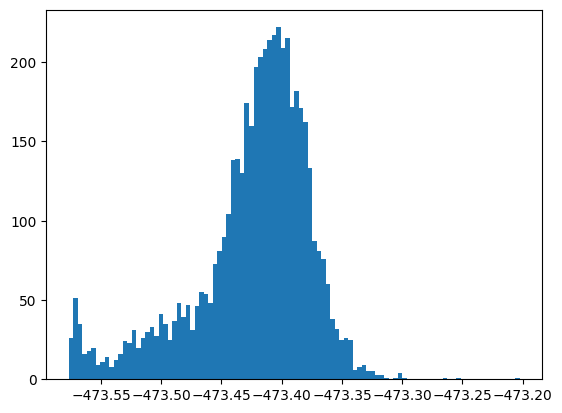

In [8]:
e = np.array([frame.info["energy [eV/H2O]"] for frame in frames])
envs = np.concatenate(
    [i * np.ones(frame.numbers.tolist().count(8), dtype=int) for i, frame in enumerate(frames)]
)
plt.hist(e, bins=100)
plt.show()
plt.close()

In [9]:
n_centers = 0
for frame in frames:
    frame.wrap(eps=1e-10)
    mask = np.zeros(len(frame), dtype=bool)
    mask[frame.numbers==8] = True
    frame.arrays['center_atoms_mask'] = mask
    n_centers += len(np.where(mask)[0])
len(frames), n_centers

(5049, 71660)

In [10]:
from ase.units import Hartree, Bohr
from ase.calculators.dftb import Dftb

def add_charges(frame, only_o=False):
    if "initial_charges" not in frame.arrays:
        directory = os.path.join(TMP_DIR.name, f"dftb_dirs/h2o-{frame.info['name']}/")
        os.makedirs(directory, exist_ok = True)
        if not os.path.exists(directory):
            os.mkdir(directory)
        if not os.path.exists(os.path.join(directory, "detailed.out")):
            calc = Dftb(
                atoms=frame,
                label=directory + "/dftb".format(frame.info["name"]),
                Hamiltonian_MaxAngularMomentum_="",
                Hamiltonian_MaxAngularMomentum_O="p",
                Hamiltonian_MaxAngularMomentum_H="s",
                kpts=(1, 1, 1),
                Hamiltonian_SCC="Yes",
                Hamiltonian_MaxSCCIterations=1000,
                Hamiltonian_Charge=0.0,
                Hamiltonian_DampXH="Yes",
                Hamiltonian_DampXHExponent=4.0,
                Hamiltonian_HubbardDerivs_="",
                Hamiltonian_HubbardDerivs_O=-0.1575,
                Hamiltonian_HubbardDerivs_H=-0.1857,
                Hamiltonian_ThirdOrderFull="Yes",
            )
            frame.calc = calc
            calc.calculate(frame)
            frame.arrays["charges"] = frame.get_charges()
        else:

            with open(os.path.join(directory, "detailed.out"), "r") as fd:
                lines = fd.readlines()

                energy = None
                for line in lines:
                    if line.strip().startswith("Total energy:"):
                        energy = float(line.split()[2]) * Hartree
                        break

                if energy is None:
                    print(frame.info["name"])
                    raise ValueError

                qm_charges = []
                chargestart = None
                for n, line in enumerate(lines):
                    if "Atom" and "Charge" in line:
                        chargestart = n + 1
                        break

                if chargestart is None:
                    print(frame.info["name"])
                    raise ValueError

                lines1 = lines[chargestart : (chargestart + len(frame))]
                for line in lines1:
                    try:
                        qm_charges.append(float(line.split()[-1]))
                    except:
                        print(frame.info['name'])
                        raise ValueError

                dipole = None
                for line in lines:
                    if "Dipole moment:" in line and "au" in line:
                        words = line.split()
                        dipole = np.array([float(w) for w in words[-4:-1]]) * Bohr
            frame.arrays["charges"] = np.array(qm_charges)
            frame.info["energy"] = energy
            frame.info["dipole"] = dipole

    if only_o:
        return frame.arrays["initial_charges"][np.where(frame.numbers == 8)[0]]
    else:
        return frame.arrays["initial_charges"]

In [11]:
charges = np.concatenate([add_charges(frame, True) for frame in tqdm(frames)])
len(charges)

  0%|          | 0/5049 [00:00<?, ?it/s]

71660

In [12]:
for frame in frames:
    if 'label' in frame.info:
        _ = frame.info.pop('label')
    frame.info['name'] = str(frame.info['name'])

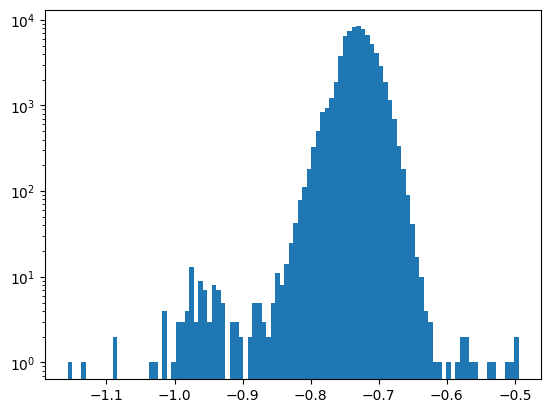

In [13]:
plt.hist(charges, bins=100)
plt.gca().set_yscale('log')
plt.show()

In [14]:
hypers = {
    'interaction_cutoff': 5,
    'max_radial': 6,
    'max_angular': 4,
    'gaussian_sigma_constant': 0.5,
    'gaussian_sigma_type': 'Constant',
    'cutoff_smooth_width': 0.1,
    'radial_basis': 'GTO',
    'normalize': False
}
soap = SOAP(**hypers)
manager = soap.transform(frames)
xa_raw = manager.get_features(soap)

In [15]:
#np.save('i_train', i_train)
#np.save('i_test', i_test)
#i_train = np.load('i_train.npy')
#i_test = np.load('i_test.npy') 

In [16]:
i_train, i_test = train_test_split(np.arange(len(xa_raw)), test_size=0.1, random_state=0)

In [17]:
X_raw = xa_raw.copy()
x_scaler = StandardFlexibleScaler(column_wise=False).fit(X_raw[i_train])
X = x_scaler.transform(X_raw)
X_train, X_test = X[i_train], X[i_test]
X.shape

(71660, 540)

In [18]:
y_scaler = StandardFlexibleScaler(column_wise=False).fit(charges[i_train].reshape((-1,1)))
y = y_scaler.transform(charges.reshape((-1,1)))

y_train, y_test = y[i_train], y[i_test]
y.shape

(71660, 1)

# Generate and Plot Linear Mappings

In [19]:
import pickle
def pull_model(model_fn, model_init=None, **model_fit_params):
    abs_path = os.path.join(TMP_DIR.name, model_fn)
    if os.path.exists(abs_path):
        model = pickle.load(open(abs_path, "rb"))
    elif model_init is not None:
        model = model_init
        model.fit(**model_fit_params)
        pickle.dump(model, open(abs_path, "wb"))
    else:
        print(f"Model {abs_path} does not exist")
        return None
    return model

In [20]:
def L2(A, Ap):
    return np.linalg.norm(A - Ap)**2.0 / np.linalg.norm(A)**2.0

def Lreg(X, PCov):
    return L2(X, PCov.inverse_transform(PCov.transform(X)))

def Lpred(X, y, PCov):
    return L2(y, PCov.predict(X))

ridge = pull_model("ridge.sav", Ridge(alpha=1E-2), X=X_train, y=y_train)
yp = ridge.predict(X)

yp_train = yp[i_train]
yp_test = yp[i_test]

L2(y, yp)

0.09626905582479485

## Survey Alphas

In [21]:
alphas = np.array(
    list(
        sorted(
            set([
                round(x, 4) for x in [
                    *np.linspace(0, 1, 11), *np.linspace(0, 0.1, 6),
                    *np.linspace(0.9, 1, 6), *np.logspace(-4, -1, 4),
                    *(1-np.logspace(-4, -1, 4)),
                ]
            ]))))
n_components = [1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 100, 200, 300, 400, 500]
errors = np.zeros((len(alphas), len(n_components), 2))
alphas

array([0.000e+00, 1.000e-04, 1.000e-03, 1.000e-02, 2.000e-02, 4.000e-02,
       6.000e-02, 8.000e-02, 1.000e-01, 2.000e-01, 3.000e-01, 4.000e-01,
       5.000e-01, 6.000e-01, 7.000e-01, 8.000e-01, 9.000e-01, 9.200e-01,
       9.400e-01, 9.600e-01, 9.800e-01, 9.900e-01, 9.990e-01, 9.999e-01,
       1.000e+00])

In [22]:
pbar2 = tqdm(total=len(alphas))
for ni, n in enumerate(tqdm(n_components)):
    for ai, alpha in enumerate(alphas):
        if errors[ai][ni][0]== 0 or np.isnan(errors[ai][ni][0]):
            pcovr = pull_model(
                f"{alpha}-{n}.sav",
                PCovR(mixing=alpha, regressor="precomputed", n_components=n),
                X=X_train,
                Y=yp_train,
                W=ridge.coef_.T,
            )
            errors[ai][ni][0] = Lreg(X_test, pcovr)
            errors[ai][ni][1] = Lpred(X_test, y_test, pcovr)
        pbar2.update(1)
    pbar2.reset(total=len(alphas))

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

4.5 0.17557660090028915 -62.31622818384549
15.0 0.11527070043209069 -16.26430851389254
25.0 0.19070069122184388 -68.6139773136002
75.0 0.16628333149280738 -59.57967234838097
150.0 0.13647809158251692 -44.647375364318655


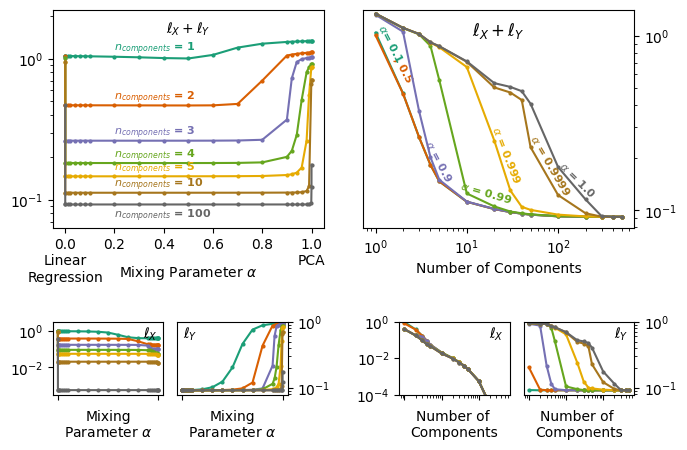

In [23]:
fig = plt.figure(figsize=(7.5, 5))
axes = fig.subplot_mosaic("""
                CCC.DDD
                .......
                AB...EF
                """,
                          gridspec_kw=dict(height_ratios=(2.25, 0.5, 0.75), width_ratios=(1,1,0.2, 0.1,0.2, 1,1)))

axX = axes["A"]
axY = axes["B"]
axXY = axes["C"]

sub_ns = [1, 2, 3, 4, 5, 10, 100]
cmap = plt.get_cmap('Dark2')

colors = [cmap(i / (len(sub_ns) - 1)) for i in range(len(sub_ns))]
for n, c in zip(sub_ns, colors):
    i = n_components.index(n)
    axY.semilogy(
        alphas,
        errors[:, i, 1],
        marker='.',  #linestyle='--', 
        markersize=4, 
        c=c)
    axX.semilogy(
        alphas,
        errors[:, i, 0],
        marker='.',  #linestyle=':', 
        markersize=4, 
        c=c)
    axXY.semilogy(alphas, errors[:, i].sum(axis=1), marker='.',
        markersize=4,  c=c)
    axXY.text(x=0.2,
              y=errors[:, i].sum(axis=1)[list(alphas).index(0.2)] if n!=sub_ns[-1] else errors[:, i].sum(axis=1)[list(alphas).index(0.2)] *0.95,
              s='$n_{{components}}$ = {}'.format(n),
              c=c,
              ha='left',
              fontsize=SMALL_FONT,
              weight='bold',
              va='bottom' if n!=sub_ns[-1] else 'top')

axX.set_xticklabels([])
axY.set_xticklabels([])

axY.annotate(text=r"$\ell_Y$",xy=(0.05, 0.95), va='top', ha='left', xycoords='axes fraction', fontsize=MEDIUM_FONT)
axX.annotate(text=r"$\ell_X$",xy=(0.95, 0.95), va='top', ha='right', xycoords='axes fraction', fontsize=MEDIUM_FONT)
axXY.annotate(text=r"$\ell_X + \ell_Y$",xy=(0.5, 0.95), va='top', ha='center', xycoords='axes fraction', fontsize=MEDIUM_FONT)

axes["A"].set_xlabel("Mixing\n"+r"Parameter $\alpha$", fontsize=MEDIUM_FONT)
axes["B"].set_xlabel("Mixing\n"+r"Parameter $\alpha$", fontsize=MEDIUM_FONT)
axes["C"].set_xlabel(r"Mixing Parameter $\alpha$", labelpad=-15, fontsize=MEDIUM_FONT)

axX.set_ylim([10**-3.5, 10**0.5])
axXY.set_ylim([10**-1.2, 10**0.35])
axY.set_ylim([10**-1.1, 10**0.0])

axY.yaxis.set_label_position("right")
axY.yaxis.tick_right()

axXY.set_xticks(np.linspace(0,1,6))
axXY.set_xticklabels(['0.0\nLinear\nRegression', 0.2, 0.4, 0.6, 0.8, '1.0\nPCA'])

axX = axes["E"]
axY = axes["F"]
axXY = axes["D"]

sub_alphas = [0.1, 0.5, 0.9, 0.99, 0.999, 0.9999, 1.0]
cmap = plt.get_cmap("Dark2")

colors = [cmap(i / (len(sub_alphas) - 1)) for i in range(len(sub_alphas))]
for alpha, c in zip(sub_alphas, colors):
    i = alphas.tolist().index(alpha)
    axY.loglog(n_components, errors[i, :, 1], marker=".", c=c, markersize=4, )  # linestyle='--',
    axX.loglog(n_components, errors[i, :, 0], marker=".", c=c, markersize=4, )  # linestyle=':',
    axXY.loglog(n_components, errors[i, :].sum(axis=1), marker=".", c=c, label=alpha, markersize=4, )

    if alpha not in [0.1, 0.5]:
        xi, xj = np.where(errors[i, :].sum(axis=1) <= 0.3)[0][:2]

        nci, ncj = n_components[xi], n_components[xj]
        ei, ej = errors[i, :].sum(axis=1)[[xi, xj]]

        angle = 1.175 * (
            180.0
            * np.arctan2(
                np.log10(ej) - np.log10(ei),
                np.log10(ncj) - np.log10(nci),
            )
            / np.pi
        )
        x = np.mean((nci, ncj))
        y = np.mean((ei, ej))
        
        if alpha in [0.9999, 1.0]:
            angle *= 1.2
            y-= 0.01
            

        print(x, y, angle)
        axXY.text(
            x=x * 1.1,
            y=y * 1.1,
            s="$\\alpha$ = {}".format(alpha),
            c=c,
            ha="center",
            fontsize=SMALL_FONT,
            weight="bold",
            rotation=angle,
            va="center",
        )

axXY.text(
    1,
    1.2,
    s="$\\alpha$= 0.1",
    c=colors[sub_alphas.index(0.1)],
    rotation=-62.5,
    ha="left",
    va="top",
    fontsize=SMALL_FONT,
    weight="bold",
    zorder=-2,
)
axXY.text(
    1.525,
    0.775,
    s=", 0.5",
    c=colors[sub_alphas.index(0.5)],
    rotation=-62.5,
    ha="left",
    va="top",
    weight="bold",
    fontsize=SMALL_FONT,
    zorder=-4,
)

axX.set_xticklabels([])
axY.set_xticklabels([])

axY.annotate(text=r"$\ell_Y$",xy=(0.95, 0.95), va='top', ha='right', xycoords='axes fraction', fontsize=MEDIUM_FONT)
axX.annotate(text=r"$\ell_X$",xy=(0.95, 0.95), va='top', ha='right', xycoords='axes fraction', fontsize=MEDIUM_FONT)
axXY.annotate(text=r"$\ell_X + \ell_Y$",xy=(0.5, 0.95), va='top', ha='center', xycoords='axes fraction', fontsize=LARGE_FONT)

axes["D"].set_xlabel("Number of Components", fontsize=MEDIUM_FONT)
axes["E"].set_xlabel("Number of \nComponents", fontsize=MEDIUM_FONT)
axes["F"].set_xlabel("Number of \nComponents", fontsize=MEDIUM_FONT)

axX.set_ylim([10**-3.5, 10**0.5])
axXY.set_ylim([10**-1.1, 10**0.15])
axY.set_ylim([10**-1.1, 10**0.0])

axY.yaxis.set_label_position("right")
axY.yaxis.tick_right()
axXY.yaxis.tick_right()

axX.set_ylim([1E-4, 1E0])
plt.savefig('pcovr-survey.pdf', bbox_inches='tight')

## PCA

In [24]:
labeled_env = np.concatenate([np.where(envs==h)[0] for h in labeled])
max(labeled_env), len(charges)

(69842, 71660)

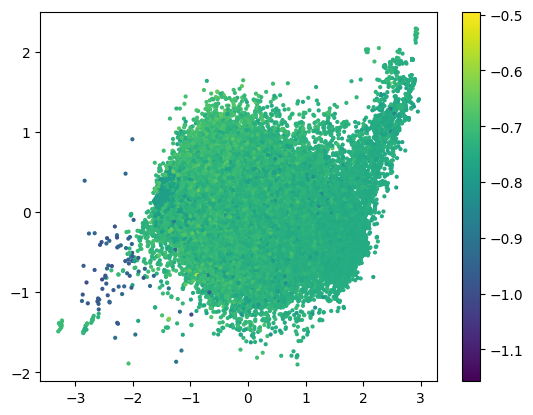

In [25]:
pca = pull_model("pca.sav", PCA(n_components=2, random_state=0), X=X_train)

t_pca = pca.transform(X)
# we reflect the firs PCA better readability
t_pca[:, 0] *= -1
plt.scatter(t_pca[:, 0], t_pca[:, 1], c=charges.flatten(), s=4)
plt.colorbar()

## PCovR

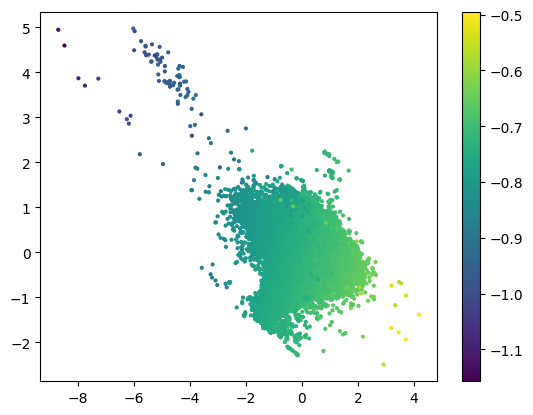

In [26]:
pcovr = pull_model("pcovr.sav", PCovR(mixing=0.5, n_components=2), X=X_train, Y=y_train)
t_pcovr = pcovr.transform(X)
plt.scatter(t_pcovr[:, 0], t_pcovr[:, 1], c=charges, s=4)
plt.colorbar()

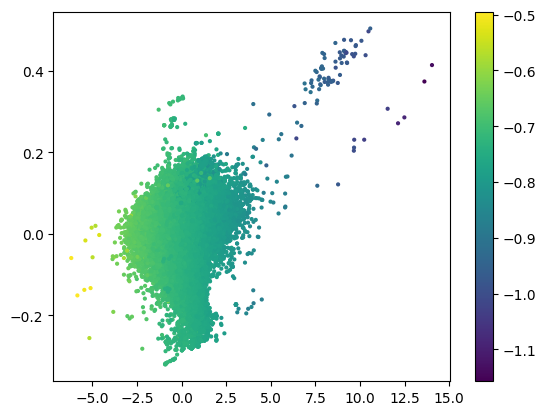

In [27]:
pcovr01 = pull_model("pcovr_01.sav", PCovR(mixing=0.01, n_components=2), X=X_train, Y=y_train)
t_pcovr01 = pcovr01.transform(X)
plt.scatter(t_pcovr01[:, 0], t_pcovr01[:, 1], c=charges, s=4)
plt.colorbar()

# Plotting

In [28]:
import matplotlib


In [29]:
paper_highlighted_envs_idx = [
    [2310, 35],
    [4426, 16],
    [4699, 22],
    [4693, 44],
    [2391, 12],
    [3968, 174],
    [2, 5], #
    [2391, 16],
    [5020, 151],
    [2625, 19],
    [225, 83],
    [321, 54],
]

In [30]:
triangle_vertices = np.array([
    [0.0, 0.0],  # Bottom-left corner
    [1.0, 0.0],  # Bottom-right corner
    [1.0, 1.0],  # Top-left corner
    [0.0, 0.0]   # Close the path
])
triangle_codes = [1, 2, 2, 79] 
lower_right_triangle = matplotlib.path.Path(triangle_vertices, triangle_codes)

triangle_vertices = np.array([
    [0.0, 0.0],  # Bottom-left corner
    [1.0, 0.0],  # Bottom-right corner
    [0.0, 1.0],  # Top-left corner
    [0.0, 0.0]   # Close the path
])
triangle_codes = [1, 2, 2, 79] 
lower_left_triangle = matplotlib.path.Path(triangle_vertices, triangle_codes)


triangle_vertices = np.array([
    [1.0, 1.0],  # Bottom-left corner
    [0.0, 1.0],  # Bottom-right corner
    [1.0, 0.0],  # Top-left corner
    [0.0, 0.0]   # Close the path
])
triangle_codes = [1, 2, 2, 79] 
upper_right_triangle = matplotlib.path.Path(triangle_vertices, triangle_codes)

triangle_vertices = np.array([
    [0.0, 1.0],  # Bottom-left corner
    [0.0, 0.0],  # Bottom-right corner
    [1.0, 1.0],  # Top-left corner
    [0.0, 0.0]   # Close the path
])
triangle_codes = [1, 2, 2, 79] 
upper_left_triangle = matplotlib.path.Path(triangle_vertices, triangle_codes)


In [31]:
print(upper_right_triangle)
print(lower_left_triangle)
print(lower_right_triangle)
print(upper_left_triangle)

Path(array([[1., 1.],
       [0., 1.],
       [1., 0.],
       [0., 0.]]), array([ 1,  2,  2, 79], dtype=uint8))
Path(array([[0., 0.],
       [1., 0.],
       [0., 1.],
       [0., 0.]]), array([ 1,  2,  2, 79], dtype=uint8))
Path(array([[0., 0.],
       [1., 0.],
       [1., 1.],
       [0., 0.]]), array([ 1,  2,  2, 79], dtype=uint8))
Path(array([[0., 1.],
       [0., 0.],
       [1., 1.],
       [0., 0.]]), array([ 1,  2,  2, 79], dtype=uint8))


In [32]:
# this is how the symols are ordered in chemiscope
markers = ["X",#
           upper_right_triangle, #
           lower_left_triangle, #
           lower_right_triangle, #
           "^",
           ">", #
           "s", #
           "v", #
           upper_left_triangle,
           "<", #
           "D", #
           "P"] #
# this is how the symols are ordered in chemiscope
markers_labels = ["X",#
           "urt", #
           "llt", #
           "lrt", #
           "^",
           ">", #
           "s", #
           "v", #
           "ult",
           "<", #
           "D", #
           "P"] #

In [33]:
assert all([frames[i].numbers[j] == 8 for i,j in paper_highlighted_envs_idx])
assert all([frames[i].arrays["center_atoms_mask"][j] for i,j in paper_highlighted_envs_idx])

In [34]:
O_lengths = [sum(frame.numbers==8) for frame in frames]
O_to_index = [{j:i for i,j in enumerate(np.where(frame.numbers==8)[0])} for frame in frames]
O_offsets = np.cumsum([0] + O_lengths)
selection_mask = np.zeros(sum(O_lengths), dtype=np.int32)
for j, sel in enumerate(paper_highlighted_envs_idx):
    selection_mask[O_offsets[sel[0]] + O_to_index[sel[0]][sel[1]]] = 1
assert len(paper_highlighted_envs_idx) == sum(selection_mask==1)

marker_labels = ["no_label"]*sum(O_lengths)
for j, sel in enumerate(paper_highlighted_envs_idx):
    marker_labels[O_offsets[sel[0]] + O_to_index[sel[0]][sel[1]]] = markers_labels[j]

In [35]:
from chemiscope import show, extract_properties

props = {"pcovr": t_pcovr, "pca": t_pca, "charges": charges, 'labels': marker_labels}
show(
    frames,
    properties=props,
    environments=[
        (i, j, 5) # structure, env, cutoff
        for i, f in enumerate(frames)
        for j in np.where(f.arrays["center_atoms_mask"])[0]
        
    ],
).save('chemiscope-oxygen-ice-structures.json.gz')

/opt/anaconda3/envs/skmatter-ore/lib/python3.8/site-packages/chemiscope/input.py:195: UserWarning: chemiscope behavior changed to no longer include properties from the structure objects. Use `chemiscope.extract_properties` to also visualize these properties ([name, edr [eV/H2O], density [g/cm3], energy [eV/H2O], energy] and [initial_charges])
  warnings.warn(


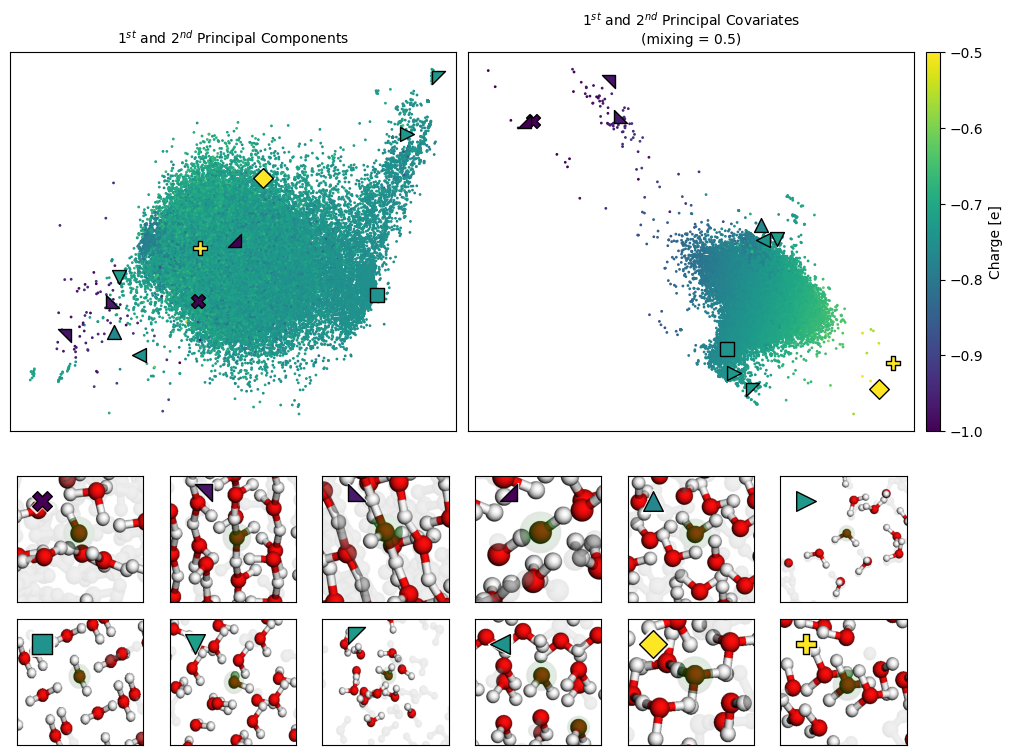

In [36]:
import matplotlib.image as mpimg

fig, axes = plt.subplot_mosaic(
    "BBBAAAC\n.......\nDEFGHI.\nJKLMNO.",
    #figsize=(7.5, 6),
    figsize=(12, 9),
    gridspec_kw=dict(height_ratios=(3, 0.1, 1,1), width_ratios=(1,1,1,1,1,1,0.1)),
#     constrained_layout=True,
)
plot_args = dict(cmap="viridis", vmin=-1.0, vmax=-0.5, rasterized=True)

p = axes["A"].scatter(t_pcovr[:, 0], t_pcovr[:, 1], c=charges, s=1, **plot_args)
# axes["A"].set_xlabel(r"PCov$_1$")
# axes["A"].set_ylabel(r"PCov$_2$")
axes["A"].set_xticks([])
axes["A"].set_yticks([])
axes["A"].set_title("1$^{st}$ and 2$^{nd}$ Principal Covariates\n(mixing = 0.5)", fontsize=MEDIUM_FONT)
p = axes["B"].scatter(t_pca[:, 0], t_pca[:, 1], c=charges, s=1, **plot_args)
# axes["B"].set_xlabel(r"PC$_1$")
# axes["B"].set_ylabel(r"PC$_2$")
axes["B"].set_xticks([])
axes["B"].set_yticks([])
axes["B"].set_title("1$^{st}$ and 2$^{nd}$ Principal Components", fontsize=MEDIUM_FONT)
plt.colorbar(p, ax=axes["A"], cax=axes["C"], label='Charge [e]', orientation='vertical')


#markers = "*svDPopXd^><"
for s, m, let in zip(paper_highlighted_envs_idx, markers, "DEFGHIJKLMNO....."):
    j = frames[s[0]].numbers[: s[1]].tolist().count(8)
    i = envs.tolist().index(s[0]) + j
    marker_size = 100 if isinstance(m, str) else 350
    axes["A"].scatter(
        t_pcovr[i, 0], t_pcovr[i, 1], c=charges[i], ec="k", s=marker_size, marker=m, **plot_args
    )
    axes["B"].scatter(
        t_pca[i, 0], t_pca[i, 1], c=charges[i], ec="k", s=marker_size, marker=m, **plot_args
    )

    img_fn = "pcovr/imgs/chemiscope-structure-{}-atom-{}.png".format(s[0] + 1, s[1] + 1)
    if os.path.exists(img_fn) and let != ".":
        axes[let].imshow(mpimg.imread(img_fn), extent=[0, 1, 0, 1], zorder=-1, aspect=1)
        axes[let].set_xticks([])
        axes[let].set_yticks([])
        marker_size = 200 if isinstance(m, str) else 600
        axes[let].scatter(
            0.2, 0.8, marker=m, c=charges[i], clip_on=False, s=marker_size, ec="k", zorder=1, **plot_args
        )
        axes[let].scatter(
            0.2, 0.8, marker=m, c='w', clip_on=False, s=marker_size+100, alpha=0.8, zorder=0
        )
        axes[let].set_ylim([0, 1])

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.savefig('pcovr-analysis.png', bbox_inches='tight', dpi=300)
plt.savefig('pcovr-analysis.pdf', bbox_inches='tight', dpi=300)

### Small Plot

In [37]:

stride = 10 # the larger the smaller the json
t_pcovr_small = np.asarray([t_pcovr[O_offsets[i] + j]
                     for i, f in enumerate(frames)
                         for j, Oidx in enumerate(np.where(f.arrays["center_atoms_mask"])[0])
                            if any([[i,Oidx] in paper_highlighted_envs_idx
                                        for j, Oidx in enumerate(np.where(f.arrays["center_atoms_mask"])[0])])
                                   or (i % stride == 0)])
t_pca_small = np.asarray([t_pca[O_offsets[i] + j]
                     for i, f in enumerate(frames)
                         for j, Oidx in enumerate(np.where(f.arrays["center_atoms_mask"])[0])
                            if any([[i,Oidx] in paper_highlighted_envs_idx
                                        for j, Oidx in enumerate(np.where(f.arrays["center_atoms_mask"])[0])])
                                   or (i % stride == 0)])

charges_small = np.asarray([charges[O_offsets[i]+j]
                     for i, f in enumerate(frames)
                         for j, Oidx in enumerate(np.where(f.arrays["center_atoms_mask"])[0])
                            if any([[i,Oidx] in paper_highlighted_envs_idx
                                        for j, Oidx in enumerate(np.where(f.arrays["center_atoms_mask"])[0])])
                                   or (i % stride == 0)])

selection_mask_small = np.asarray([selection_mask[O_offsets[i]+j]
                     for i, f in enumerate(frames)
                         for j, Oidx in enumerate(np.where(f.arrays["center_atoms_mask"])[0])
                            if any([[i,Oidx] in paper_highlighted_envs_idx
                                        for j, Oidx in enumerate(np.where(f.arrays["center_atoms_mask"])[0])])
                                   or (i % stride == 0)])

marker_labels_small = [marker_labels[O_offsets[i]+j]
                     for i, f in enumerate(frames)
                         for j, Oidx in enumerate(np.where(f.arrays["center_atoms_mask"])[0])
                            if any([[i,Oidx] in paper_highlighted_envs_idx
                                        for j, Oidx in enumerate(np.where(f.arrays["center_atoms_mask"])[0])])
                                   or (i % stride == 0)]

assert sum(selection_mask_small) == sum(selection_mask), f"{sum(selection_mask_small)} !=  {sum(selection_mask)}"
props_small = {
        "pcovr": t_pcovr_small,
        "pca": t_pca_small,
        "charges": charges_small,
        "labels": marker_labels_small}

pair_idx = [[i,Oidx] for i, f in enumerate(frames)
     for j, Oidx in enumerate(np.where(f.numbers == 8)[0])
         if ([i,Oidx] in paper_highlighted_envs_idx) or (i % stride == 0)]
idx_frame = np.unique(np.array(pair_idx)[:, 0])
frames_small = [frames[i] for i in idx_frame]

assert len(t_pca_small) == len(t_pcovr_small)
assert len(t_pca_small) == len(charges_small)
assert len(t_pca_small) == len(selection_mask_small)
assert len(t_pca_small) == len(marker_labels_small)

environments = [
        (i, Oidx, 5) # structure, env, cutoff
            for i, f in enumerate(frames_small)
                for Oidx in np.where(f.arrays["center_atoms_mask"])[0]]

assert len(t_pca_small) == len(environments)


assert len(paper_highlighted_envs_idx) == sum(selection_mask_small==1), f"{len(paper_highlighted_envs_idx)} != {sum(selection_mask_small==1)}"



In [38]:
show(
    frames_small,
    properties=props_small,
    environments=environments,
).save('chemiscope-oxygen-ice-structures-small.json')

In [39]:
import json

with open('chemiscope-oxygen-ice-structures-small.json', 'r') as f:
    json_content = json.loads(f.read())
# automatic generated settings
settings = '{"map":{"x":{"max":4.772170932643184,"min":-8.942112036053794,"property":"pcovr[1]","scale":"linear"},"y":{"max":5.100710761292653,"min":-2.803941737364797,"property":"pcovr[2]","scale":"linear"},"z":{"max":0,"min":0,"property":"","scale":"linear"},"symbol":"labels","palette":"inferno","color":{"mode":"linear","property":"charges","min":-1.13325632,"max":-0.49459438},"size":{"factor":50,"mode":"linear","property":"","reverse":false}},"pinned":[503],"structure":[{"bonds":true,"spaceFilling":false,"atomLabels":false,"shape":"","unitCell":false,"rotation":false,"supercell":{"0":1,"1":1,"2":1},"axes":"off","keepOrientation":false,"playbackDelay":700,"environments":{"activated":true,"bgColor":"grey","bgStyle":"ball-stick","center":false,"cutoff":5}}]}'
json_content['settings'] = json.loads(settings)
import gzip
with gzip.open('chemiscope-oxygen-ice-structures-small.json.gz', 'wb') as f:
    c = str.encode(json.dumps(json_content))
    f.write(c)

In [40]:
paper_highlighted_envs_idx_small = []
for k, Oidx in paper_highlighted_envs_idx:
    ref_env = frames[k][Oidx]
    for i in range(len(frames_small)):
        for j in range(len(frames_small[i])):
            if len(frames_small[i]) >= j+1 and np.allclose(ref_env.position, frames_small[i][j].position):
                print(k, Oidx)
                paper_highlighted_envs_idx_small.append([i, j])
                break
assert len(paper_highlighted_envs_idx_small) == len(paper_highlighted_envs_idx)                

2310 35
4426 16
4699 22
4693 44
2391 12
3968 174
2 5
2391 16
5020 151
2625 19
225 83
321 54


In [41]:
Ooffsets_small = np.cumsum([0] + [sum(frame.numbers==8) for frame in frames_small])

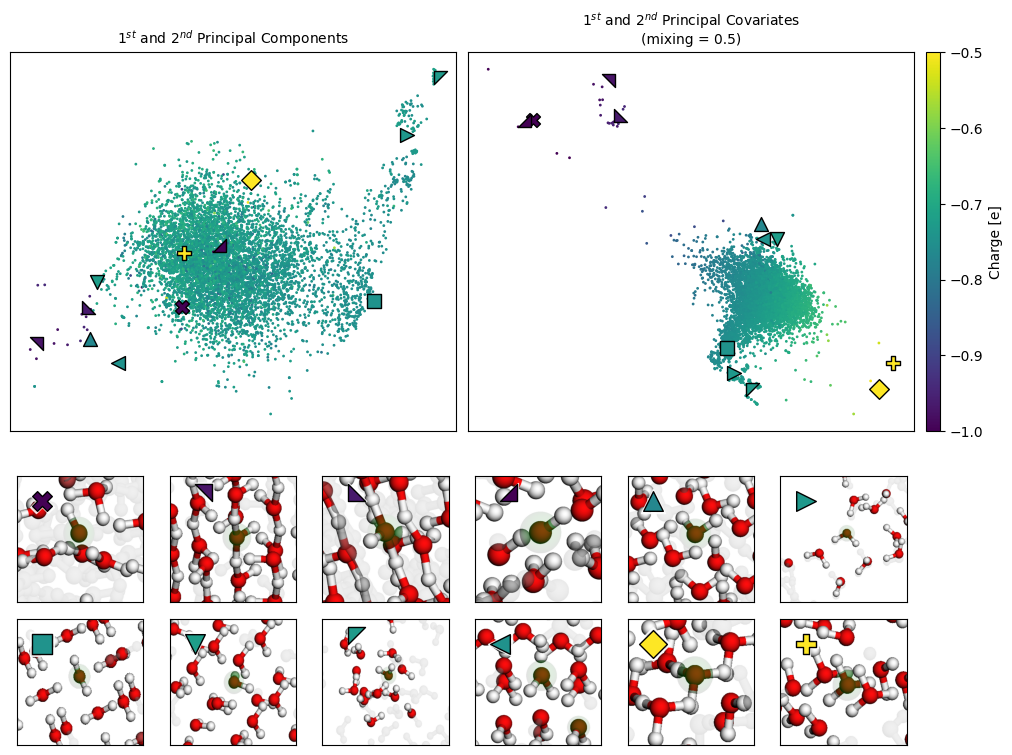

In [42]:
import matplotlib.image as mpimg

fig, axes = plt.subplot_mosaic(
    "BBBAAAC\n.......\nDEFGHI.\nJKLMNO.",
    #figsize=(7.5, 6),
    figsize=(12, 9),
    gridspec_kw=dict(height_ratios=(3, 0.1, 1,1), width_ratios=(1,1,1,1,1,1,0.1)),
#     constrained_layout=True,
)
plot_args = dict(cmap="viridis", vmin=-1.0, vmax=-0.5, rasterized=True)

p = axes["A"].scatter(t_pcovr_small[:, 0], t_pcovr_small[:, 1], c=charges_small, s=1, **plot_args)
# axes["A"].set_xlabel(r"PCov$_1$")
# axes["A"].set_ylabel(r"PCov$_2$")
axes["A"].set_xticks([])
axes["A"].set_yticks([])
axes["A"].set_title("1$^{st}$ and 2$^{nd}$ Principal Covariates\n(mixing = 0.5)", fontsize=MEDIUM_FONT)
p = axes["B"].scatter(t_pca_small[:, 0], t_pca_small[:, 1], c=charges_small, s=1, **plot_args)
# axes["B"].set_xlabel(r"PC$_1$")
# axes["B"].set_ylabel(r"PC$_2$")
axes["B"].set_xticks([])
axes["B"].set_yticks([])
axes["B"].set_title("1$^{st}$ and 2$^{nd}$ Principal Components", fontsize=MEDIUM_FONT)
plt.colorbar(p, ax=axes["A"], cax=axes["C"], label='Charge [e]', orientation='vertical')


#markers = "*svDPopXd^><"
for ss, s, m, let in zip(paper_highlighted_envs_idx, paper_highlighted_envs_idx_small, markers, "DEFGHIJKLMNO....."):
    j = frames_small[s[0]].numbers[: s[1]].tolist().count(8)
    i = Ooffsets_small[s[0]] +j 

    marker_size = 100 if isinstance(m, str) else 350
    axes["A"].scatter(
        t_pcovr_small[i, 0], t_pcovr_small[i, 1], c=charges_small[i], ec="k", s=marker_size, marker=m, **plot_args
    )
    axes["B"].scatter(
        t_pca_small[i, 0], t_pca_small[i, 1], c=charges_small[i], ec="k", s=marker_size, marker=m, **plot_args
    )
    img_fn = "pcovr/imgs/chemiscope-structure-{}-atom-{}.png".format(ss[0] + 1, ss[1] + 1)
    if os.path.exists(img_fn) and let != ".":
        axes[let].imshow(mpimg.imread(img_fn), extent=[0, 1, 0, 1], zorder=-1, aspect=1)
        axes[let].set_xticks([])
        axes[let].set_yticks([])
        marker_size = 200 if isinstance(m, str) else 600
        axes[let].scatter(
            0.2, 0.8, marker=m, c=charges_small[i], clip_on=False, s=marker_size, ec="k", zorder=1, **plot_args
        )
        axes[let].scatter(
            0.2, 0.8, marker=m, c='w', clip_on=False, s=marker_size+100, alpha=0.8, zorder=0
        )

        axes[let].set_ylim([0, 1])

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.savefig('pcovr-analysis-small.png', bbox_inches='tight', dpi=300)
plt.savefig('pcovr-analysis-small.pdf', bbox_inches='tight', dpi=300)

In [43]:
#TMP_DIR.cleanup()